# Inference Attack with AutoML and Fashion MNIST -- Trial \#1
ISU CEADS Lab under Dr. Leslie Kerby <br>
Samantha Ross <br><br>

This is a notebook detailing an inference attack (or "model stealing") against a target with an architecture utilizing EfficientNetB0. The attack uses AutoML (AutoKeras) and the Fashion MNIST data set.

## TensorFlow Versioning
TensorFlow has now updated to v2.12. This notebook was originally created using TensorFlow v2.11. Given the simplicity of this data set, there was no need to save models in case of a notebook crash (from exceeding resources). If there are problems serializing the model, this is an internal TensorFlow error with certain EfficientNet models and the solution is to use "EfficientNetV2B0" instead of "EfficientNetB0."

# Imports

In [ ]:
# Installs and Imports
!pip install autokeras

import autokeras as ak
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

# Dataset Preparation 
Loading in, preprocessing, and creating a train-test-split of the Fashion MNIST Digits data. The Fashion MNIST dataset is a 10 class dataset of 28x28 grayscale, labeled fashion images. It has a default split of 60k in training and 10k in testing.

In [ ]:
# Loading Data
# Dataset from TFDS
import tensorflow_datasets as tfds

(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split = ['train[:90%]', 'train[90%:]', 'test'], # 90% training set in ds_train and 10% in ds_valid
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)
ds_train

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Build transformation pipeline for TFDS Datasets 
def preprocess(image, label): 
  image = tf.image.resize(image, [32, 32]) # 32x32 pixels (vs 224x224)
  return (image, label)

def data_aug(image, label):
  image = tf.image.random_flip_left_right(image)
  return (image, label)

# apply -- and apply data augmentation to training set only
ds_train = ds_train.map(preprocess).map(data_aug).batch(32).prefetch(1)
ds_valid = ds_valid.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)

# Victim Model
CNN Model utilizing EfficientNetB0 (same as MNIST Digits EfficientNetB0 model) <br>
Uses data augmentation and transfer learning

In [ ]:

base_model = keras.applications.EfficientNetB0(weights="imagenet", 
                                              include_top=False,
                                             input_shape=(32,32,3)) # don't nec need 224x224 (needs at least 32x32)
global_avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
dropout = keras.layers.Dropout(0.02)(global_avg)
output = keras.layers.Dense(10, activation="softmax")(dropout)
victim_model3 = keras.models.Model(inputs=base_model.input, outputs=output)

## Training
Using transfer learning

In [ ]:
# Freeze transferred layers and train
%%time
for layer in base_model.layers:
    layer.trainable = False

victim_model3.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-3),
                metrics=["accuracy"])

history_vict = victim_model3.fit(ds_train, 
                    epochs=15, validation_data=ds_valid, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/15


1688/1688 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.7083

1688/1688 [==============================] - 69s 31ms/step - loss: 0.9234 - accuracy: 0.7083 - val_loss: 0.6587 - val_accuracy: 0.7773
Epoch 2/15
1688/1688 [==============================] - 41s 25ms/step - loss: 0.6649 - accuracy: 0.7741 - val_loss: 0.5819 - val_accuracy: 0.7993
Epoch 3/15
1688/1688 [==============================] - 46s 27ms/step - loss: 0.6158 - accuracy: 0.7876 - val_loss: 0.5458 - val_accuracy: 0.8140
Epoch 4/15
1688/1688 [==============================] - 34s 20ms/step - loss: 0.5846 - accuracy: 0.7961 - val_loss: 0.5344 - val_accuracy: 0.8143
Epoch 5/15
1688/1688 [==============================] - 51s 30ms/step - loss: 0.5690 - accuracy: 0.8028 - val_loss: 0.5080 - val_accuracy: 0.8250
Epoch 6/15
1688/1688 [==============================] - 46s 27ms/step - loss: 0.5560 - accuracy: 0.8060 - val_loss: 0.4959 - val_accuracy: 0.8295
Epoch 7/15
1688/1688 [==============================] - 34s 20ms/step - loss: 0.5451 - accuracy: 0.8078 - val_loss: 0.4883 - val_accura

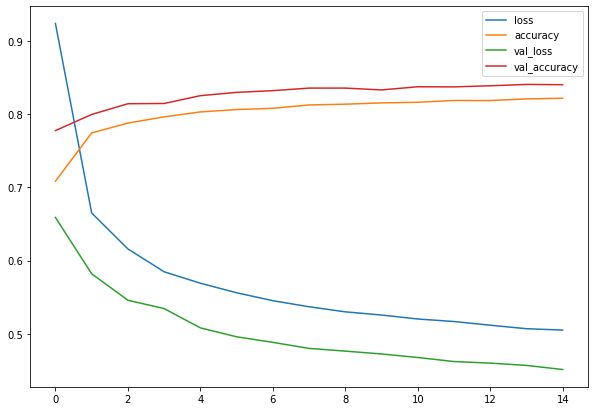

In [ ]:
# Graph
pd.DataFrame(history_vict.history).plot(figsize=(10,7)) 

In [ ]:
history_vict.model.evaluate(ds_test)

313/313 [==============================] - 6s 18ms/step - loss: 0.4704 - accuracy: 0.8362


[0.47036826610565186, 0.8361999988555908]

In [ ]:
# Unfreeze layers and train
%%time
for layer in base_model.layers:
    layer.trainable = True

victim_model3.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.Nadam(1e-4),
                metrics=["accuracy"])

n_epochs = 20
history_vict2 = victim_model3.fit(ds_train,
                    epochs=n_epochs,
                    validation_data=ds_valid,
                    callbacks=[keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/20


1688/1688 [==============================] - ETA: 0s - loss: 2.6710 - accuracy: 0.6154

1688/1688 [==============================] - 188s 97ms/step - loss: 2.6710 - accuracy: 0.6154 - val_loss: 0.8642 - val_accuracy: 0.7670
Epoch 2/20
1688/1688 [==============================] - 137s 81ms/step - loss: 0.7388 - accuracy: 0.7782 - val_loss: 0.5073 - val_accuracy: 0.8320
Epoch 3/20
1688/1688 [==============================] - 135s 80ms/step - loss: 0.4918 - accuracy: 0.8324 - val_loss: 0.3974 - val_accuracy: 0.8582
Epoch 4/20
1688/1688 [==============================] - 137s 81ms/step - loss: 0.3813 - accuracy: 0.8664 - val_loss: 0.3599 - val_accuracy: 0.8733
Epoch 5/20
1688/1688 [==============================] - 134s 79ms/step - loss: 0.3076 - accuracy: 0.8886 - val_loss: 0.3377 - val_accuracy: 0.8812
Epoch 6/20
1688/1688 [==============================] - 135s 80ms/step - loss: 0.2421 - accuracy: 0.9112 - val_loss: 0.3248 - val_accuracy: 0.8870
Epoch 7/20
1688/1688 [==============================] - 134s 79ms/step - loss: 0.1980 - accuracy: 0.9276 - val_loss: 0.3189 - val

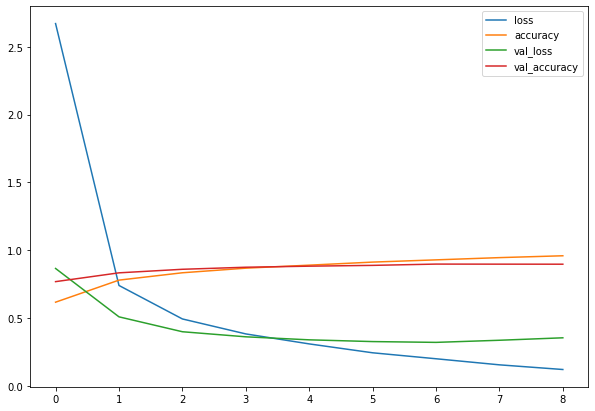

In [ ]:
# Graph
pd.DataFrame(history_vict2.history).plot(figsize=(10,7)) 

In [ ]:
victim_model3.evaluate(ds_test)

313/313 [==============================] - 4s 14ms/step - loss: 0.3887 - accuracy: 0.8925


[0.3887072801589966, 0.8924999833106995]

## Predictions, Misclassifieds, and CM

In [ ]:
y_pred = np.argmax(victim_model3.predict(ds_test), axis=-1)
print(y_pred[:10])

313/313 [==============================] - 5s 11ms/step
[4 4 9 7 5 1 0 5 7 4]


In [ ]:
# get y_test from ds_test
y_test = np.concatenate([y for x, y in ds_test], axis=0)

print(y_pred[:20]) # Victim Model
print(y_test[:20]) # Actual

[4 4 9 7 5 1 0 5 7 4 0 8 2 3 9 0 7 7 6 2]
[4 4 9 7 5 1 0 5 7 4 0 8 2 3 9 0 7 7 2 2]


In [ ]:
# get X_test from ds_test (**uses a lot of RAM)
train_ds = ds_test.unbatch()
X_test = np.asarray(list(train_ds.map(lambda x, y: x)))
print(X_test.shape)

(10000, 32, 32, 1)


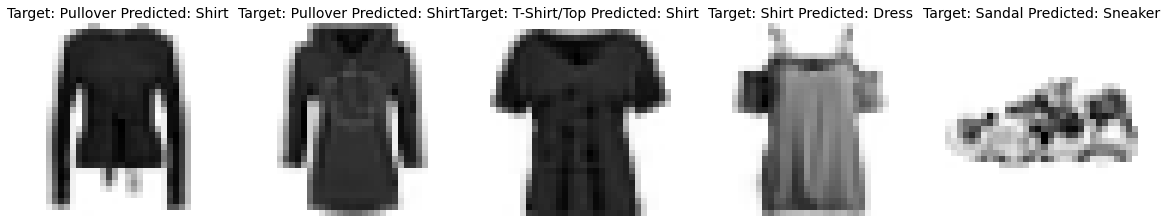

In [ ]:
# Display misclassified images for this experimental model
classes = ['T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, y_pred):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(32,32), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test[misclassifiedIndexes[index]]]} Predicted: {classes[y_pred[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

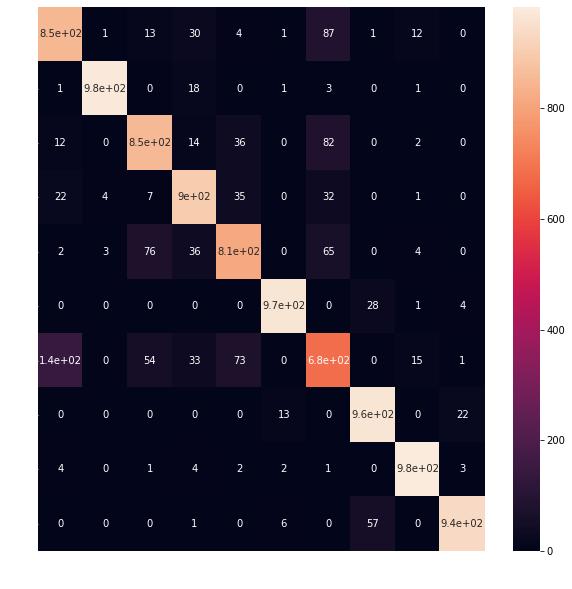

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

# Model Stealing
Reverse engineering the target model by generating an attack model with AutoKeras

In [ ]:
# split victim test data from a subset of the dataset images (X_test) and 
# the victim's predictions on that data (y_pred)
X_train_tr2, X_test2, y_train_tr2, y_test2 = train_test_split(X_test, y_pred,
                                                                test_size=3/10)
print(X_test.shape)
print(y_test2.shape)

print()
print(X_train_tr2.shape)
print(X_test2.shape)
print(y_train_tr2.shape)
print(y_test2.shape)

(10000, 32, 32, 1)
(3000,)

(7000, 32, 32, 1)
(3000, 32, 32, 1)
(7000,)
(3000,)


In [ ]:
# initialize AK image classifier that will try 2 models (for time)
auto_model = ak.ImageClassifier(max_trials=2, loss = 'sparse_categorical_crossentropy') # specifying loss

# AK defaults to binary_crossentropy or categorical_crossentropy depending on # of classes
# Changing (specifying) sparse_categorical for victim-->attack prediction data compatability

In [ ]:
# Search for the best model
am5_history = auto_model.fit(X_train_tr2, y_train_tr2, 20,
                 callbacks=[keras.callbacks.EarlyStopping(patience=2)]) 

Trial 2 Complete [00h 06m 46s]
val_loss: 0.9206004738807678

Best val_loss So Far: 0.36378756165504456
Total elapsed time: 00h 06m 58s
Epoch 1/20
219/219 [==============================] - 1s 5ms/step - loss: 0.6581 - accuracy: 0.7591
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.4237 - accuracy: 0.8483
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.3698 - accuracy: 0.8646
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.3410 - accuracy: 0.8789
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.3138 - accuracy: 0.8884
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2851 - accuracy: 0.8956
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2693 - accuracy: 0.9020
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2538 - accuracy: 0.9073
Epoch 9/20
219/219 [==============================] - 1s 4ms/step

In [ ]:
auto_model.evaluate(X_test2, y_test2)

94/94 [==============================] - 1s 6ms/step - loss: 0.5077 - accuracy: 0.8710


[0.5076953172683716, 0.8709999918937683]

## Export Best Model
Export the best model.

In [ ]:
stolen_model = auto_model.export_model()
stolen_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 1)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0     

## Predictions, Missclassifieds and CM

In [ ]:
attack_pred = np.argmax(stolen_model.predict(X_test2), axis=-1)
print(attack_pred[:10])

94/94 [==============================] - 0s 4ms/step
[5 3 7 4 6 1 8 1 5 5]


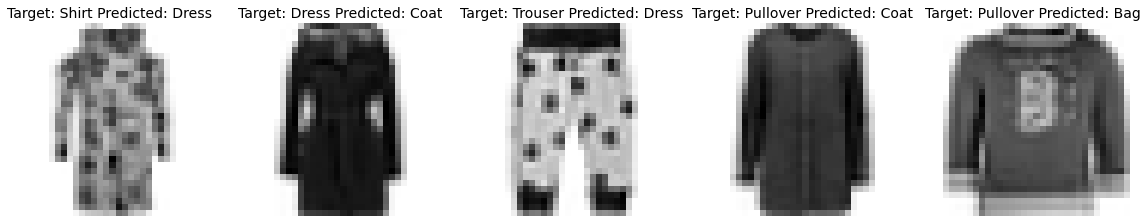

In [ ]:
# Display misclassified images for this experimental model
classes = ['T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test2, attack_pred):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

misclassifiedIndexes

plt.figure(figsize=(20,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test2[misclassifiedIndexes[index]].reshape(32,32), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {classes[y_test2[misclassifiedIndexes[index]]]} Predicted: {classes[attack_pred[misclassifiedIndexes[index]]]}', fontsize=14)

plt.show()

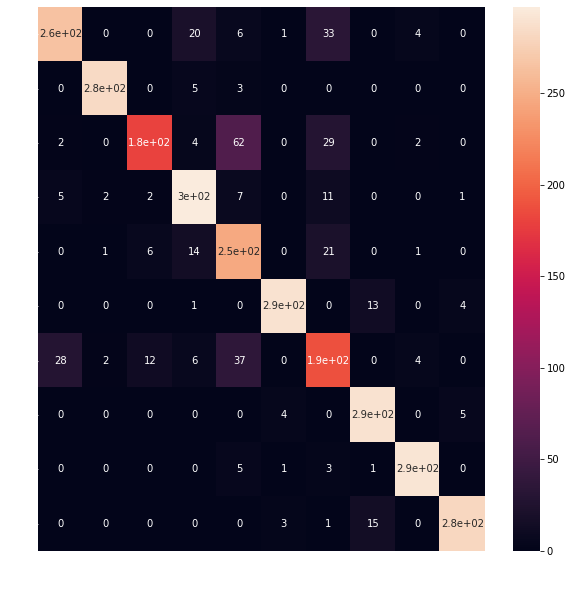

In [ ]:
# Confusion Matrix of the attack model on its own predictions / actual labels

cm = confusion_matrix(y_test2, attack_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

## Functional Equivalence Assessment

#### Individual Test Data 
How well did each predict their individual test data

In [ ]:
# Look at first 30 predictions and compare with actual
print(y_pred[:30]) # Victim Model Predictions --> predicted X_test
print(y_test[:30]) # y test data for victim
print()
print(attack_pred[:30]) # Attack Model Predictions --> predicted X_test2
print(y_test2[:30]) # y test data for attack

[4 4 9 7 5 1 0 5 7 4 0 8 2 3 9 0 7 7 6 2 0 4 4 4 6 7 7 4 2 4]
[4 4 9 7 5 1 0 5 7 4 0 8 2 3 9 0 7 7 2 2 0 4 4 4 2 7 7 4 2 4]

[5 3 7 4 6 1 8 1 5 5 3 7 7 8 7 8 4 7 4 8 7 6 9 4 8 1 3 9 7 3]
[5 6 7 3 6 1 8 1 5 5 1 7 7 8 7 8 4 7 2 2 7 6 9 4 8 1 3 9 7 0]


#### Attack Model on Victim Model's Data**
How well can the attack model predict the victim model's data (X_test)<br>

In [ ]:
# get attack model predictions on X_test (victim model test data)
attack_pred2 = np.argmax(stolen_model.predict(X_test), axis=-1) # attack model predictions given same data as original model
print(attack_pred2[:10])

313/313 [==============================] - 1s 2ms/step
[4 4 9 7 5 1 0 5 7 4]


In [ ]:
# Look at first 30 predictions
print(y_pred[:30]) # Victim Model Predictions (unchanged --> uses X_test)
print(attack_pred2[:30]) # Attack Model Predictions --> on X_test
# Compare with actual values
print(y_test[:30]) # Victim Model test data (actual)

[4 4 9 7 5 1 0 5 7 4 0 8 2 3 9 0 7 7 6 2 0 4 4 4 6 7 7 4 2 4]
[4 4 9 7 5 1 0 5 7 4 0 8 2 3 9 0 7 7 6 2 0 4 4 4 6 7 7 4 2 4]
[4 4 9 7 5 1 0 5 7 4 0 8 2 3 9 0 7 7 2 2 0 4 4 4 2 7 7 4 2 4]


#### Victim Model on Attack Model's Data
How well does the original model predict on the data from the stolen model (data: X_test2)?

In [ ]:
test_pred = np.argmax(stolen_model.predict(X_test2), axis=-1)
print(test_pred[:10])

94/94 [==============================] - 0s 3ms/step
[5 3 7 4 6 1 8 1 5 5]


In [ ]:
# Look at first 30 predictions
print(test_pred[:30]) # Victim Model Predictions (using X_test2 instead of X_test)
print(attack_pred[:30]) # Attack Model Predictions (unchanged --> uses X_test2)
print(y_test2[:30]) # y values for X_test2

[5 3 7 4 6 1 8 1 5 5 3 7 7 8 7 8 4 7 4 8 7 6 9 4 8 1 3 9 7 3]
[5 3 7 4 6 1 8 1 5 5 3 7 7 8 7 8 4 7 4 8 7 6 9 4 8 1 3 9 7 3]
[5 6 7 3 6 1 8 1 5 5 1 7 7 8 7 8 4 7 2 2 7 6 9 4 8 1 3 9 7 0]
